<a href="https://colab.research.google.com/github/Shuvam1024/compsr/blob/main/SRCompA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural network for image super-resolution on compressed images

**Author:** [Shuvam Mukherjee](shuvam1024@gmail.com)<br>
**Date created:** 08/01/2021<br>
**Last modified:** 12/23/2021<br>
**Description:** Train a deep convolutional network for joint super-resolution and compression artifact removal. 

## Introduction

This example demonstrates how to implement a deep convolutional network
for joint super-resolution and image compression noise mitigation.

## Setup and Helper functions

In [ ]:
# Tensorflow setup - one-time

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For the latest nightly build (if needed):
# !pip install tf-nightly

# For getting flops for a model
!pip install keras-flops

Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorflow-io-gcs-filesystem, gast, absl-py, google-pasta, keras-preprocessing, tensorflow-estimator, six, typing-extensions, libclang, h5py, wheel, protobuf, tensorboard, grpcio, termcolor, astunparse, numpy, opt-einsum, wrapt, keras, flatbuffers
Required-by: kapre


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from io import BytesIO
import requests

from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow import pad

# If keras-flops does not exist, install keras-flops package as shown above
from keras_flops import get_flops

def load_url(url):
    """
    Load npz file from a url
    """
    r = requests.get(url, stream = True)
    x = np.load(BytesIO(r.raw.read()))
    data = x['data']
    noisy_data = x['noisy_data']
    patchsize = x['patchsize'].item(0)
    return data, noisy_data, patchsize

def preprocess(array, patchsize):
    """
    Normalizes the supplied array to the [0.0, 1.0] range and reshapes it into
    the appropriate format.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), patchsize, patchsize, 1))
    return array

def round_postpredict(array):
    """
    Rounds and clamps array from floating point [0.0, 1.0] range for source
    to 8-bit [0, 255] range after prediction by scaling by 255 and clamping. 
    The resultant data is then converted back to floating point [0.0, 1.0]
    range by dividing by 255.0
    """
    array = np.ndarray.round(array * 255.0) 
    array = np.clip(array, 0.0, 255.0) / 255.0
    return array

def get_mse(x, y):
    """
    Gets mse of two tensors of size [batchize, height, width]
    """
    mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    return mse(x, y).numpy()

def display2(array1, array2, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def display3(array1, array2, array3, patchsize):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 12
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(image3.reshape(patchsize, patchsize))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Setup URLs for Training, Validation and Test Sets

In [ ]:
# Choose quality as one of {20, 30, 40, 50}
quality = '50'

# Choose one of {2by1, 8by5, 4by3}
ratio = '2by1'

# Training and Validation set urls (use the ratio and quality strings above)
train_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + '/DIV2K_train_' + ratio + '_' + quality + '_48x48.npz'
valid_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + '/DIV2K_valid_' + ratio + '_' + quality + '_48x48.npz'

# Where to store the trained models.
# Assume they are to be stored in your personal gdrive in 'Colab Notebooks' folder. Change this as you wish.
model_out = 'gdrive/My Drive/Colab Notebooks/model_' + ratio + '_' + quality + 'A.keras'

# Test set url
test_url = 'https://storage.googleapis.com/srcompdata/Ratio_' + ratio + '/DIV2K_test_' + ratio + '_' + quality + '_64x64.npz'

print('train_url: ' + train_url)
print('valid_url: ' + valid_url)
print('test_url:  ' + test_url)
print('model_out: ' + model_out)

train_url: https://storage.googleapis.com/srcompdata/Ratio_2by1/DIV2K_train_2by1_50_48x48.npz
valid_url: https://storage.googleapis.com/srcompdata/Ratio_2by1/DIV2K_valid_2by1_50_48x48.npz
test_url:  https://storage.googleapis.com/srcompdata/Ratio_2by1/DIV2K_test_2by1_50_64x64.npz
model_out: gdrive/My Drive/Colab Notebooks/model_2by1_50.keras


## Load and prepare the data, visualize and get stats

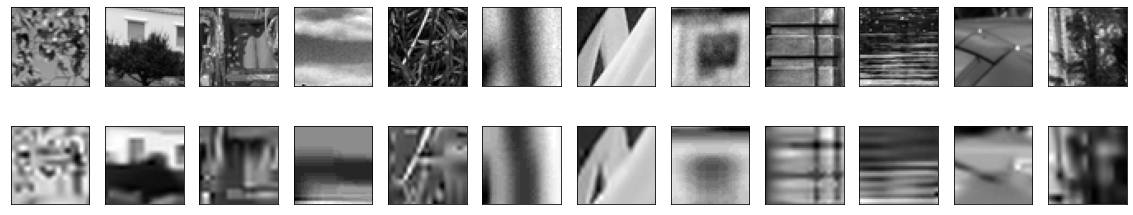

Training Noisy MSE: 0.0022745535
Validation Noisy MSE: 0.0024433741


In [ ]:
# Load Training and Validation Data
train_data, noisy_train_data, patchsize = load_url(train_url)
valid_data, noisy_valid_data, vpatchsize = load_url(valid_url)

assert patchsize == vpatchsize

# Normalize and reshape the data
train_data = preprocess(train_data, patchsize)
noisy_train_data = preprocess(noisy_train_data, patchsize)
valid_data = preprocess(valid_data, patchsize)
noisy_valid_data = preprocess(noisy_valid_data, patchsize)

# Display the train data and a version of it with added noise
display2(train_data, noisy_train_data, patchsize)

# Compute Noisy MSE for training and validation sets for reference
loss_noisy_train = get_mse(train_data, noisy_train_data)
print('Training Noisy MSE: ' + str(loss_noisy_train))
loss_noisy_valid = get_mse(valid_data, noisy_valid_data)
print('Validation Noisy MSE: ' + str(loss_noisy_valid))

## Build the CNN

We are going to use the Functional API to build our convolutional neural network.

In [ ]:
def generate_cnn(input_size=None):

  my_learning_rate = 0.001

  input = layers.Input(shape=(input_size, input_size, 1))

  x = layers.Conv2D(32, (5, 5), activation="tanh", strides=(1, 1), padding="same")(input)
  x = layers.Conv2D(28, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(24, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(20, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
  x = layers.Conv2D(1, (5, 5), activation="tanh", padding="same")(x)
  output = layers.Add()([input, x])

  # CNN
  cnn = Model(input, output)
  cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="mean_squared_error", metrics=['mse'])

  return cnn

my_cnn = generate_cnn()
my_cnn.summary()

# To get FLOPS need to use a model with any non-None input shape
# Then to get flops per pixel divide by number of pixels
sz = 128
my_cnn2 = generate_cnn(sz)
flops_per_pixel = get_flops(my_cnn2, batch_size=1) / (sz * sz)
print(f"FLOPS Per Pixel: {flops_per_pixel} ")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   832         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   8092        ['conv2d[0][0]']                 
                                28)                                                           

Now that we have our network, let's train it using the noisy
data as our input and the clean data as our target. We want our CNN to learn how to super-resolve images in the presencce of compression noise.

In [ ]:
# Mount your Google drive to write the model generated
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Train network
my_cnn.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=40,
    batch_size=512,
    shuffle=True,
    validation_data=(noisy_valid_data, valid_data),
)

# Save trained network
my_cnn.save(model_out)

Epoch 1/20
706/706 [==============================] - 38s 50ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 3/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/20
706/706 [==============================] - 34s 48ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/20
706/706 [==============================] - 34s 48ms

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Let's now predict on the noisy validation data and display the results of our trained network.

Notice how the CNN reduces the MSE between the source and the noisy images.

Mounted at /content/gdrive


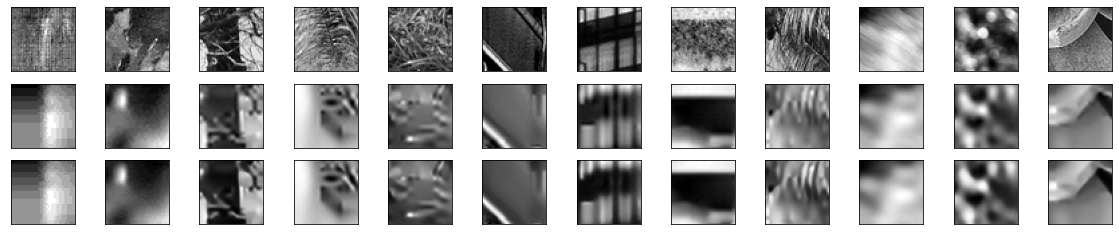

Validation Restored MSE: 0.0023198207
Validation MSE Reduction %: 5.056673288345337


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

my_cnn = tf.keras.models.load_model(model_out)

restored_valid_data = round_postpredict(my_cnn.predict(noisy_valid_data))
display3(valid_data, noisy_valid_data, restored_valid_data, patchsize)

loss_restored_valid = get_mse(valid_data, restored_valid_data)
print('Validation Restored MSE: ' + str(loss_restored_valid))
valid_loss_pct = (loss_noisy_valid - loss_restored_valid) / loss_noisy_valid * 100
print('Validation MSE Reduction %: ' + str(valid_loss_pct))

## Test your network on test data.

Mounted at /content/gdrive
Test Noisy MSE: 0.0022601327
Test Restored MSE: 0.002113
Test MSE Reduction %: 6.509912759065628


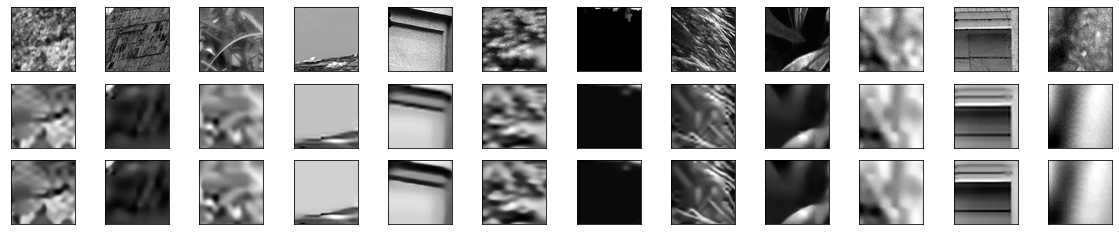

In [ ]:
# Load the trained model and test the reduction in MSE achieved
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load the test data
test_data, noisy_test_data, testpatchsize = load_url(test_url)

my_cnn = tf.keras.models.load_model(model_out)

# Normalize and reshape the data
test_data = preprocess(test_data, testpatchsize)
noisy_test_data = preprocess(noisy_test_data, testpatchsize)
loss_noisy_test = get_mse(test_data, noisy_test_data)
print('Test Noisy MSE: ' + str(loss_noisy_test))

restored_test_data = round_postpredict(my_cnn.predict(noisy_test_data))
loss_restored_test = get_mse(test_data, restored_test_data)
print('Test Restored MSE: ' + str(loss_restored_test))

test_loss_pct = (loss_noisy_test - loss_restored_test) / loss_noisy_test * 100
print('Test MSE Reduction %: ' + str(test_loss_pct))

display3(test_data, noisy_test_data, restored_test_data, testpatchsize)